In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, OrdinalEncoder, LabelEncoder, MaxAbsScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics         import make_scorer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings

from datetime import date
filterwarnings('ignore')

%matplotlib inline

sns.set(style="darkgrid")
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

**Task 1**. We will be working with data from the [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) competition, which was about predicting the duration of a taxi trip. Download the training sample from this competition and upload it:

In [2]:
train = pd.read_csv('train/train.csv')

In [3]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


Pay attention to the `pickup_datetime` and `dropoff_datetime` columns. `dropoff_datetime` was added only to the training sample, so, this column cannot be used, let's delete it. `pickup_datetime` contains the date and time the trip started. To make it convenient to work with, let's convert dates to `datetime` objects

In [4]:
train = train.drop('dropoff_datetime', axis=1)
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)

target = 'trip_duration'

The `trip_duration` column contains the target value we want to predict. Let's look at the distribution of the target in the training sample. To do this, draw its histogram:

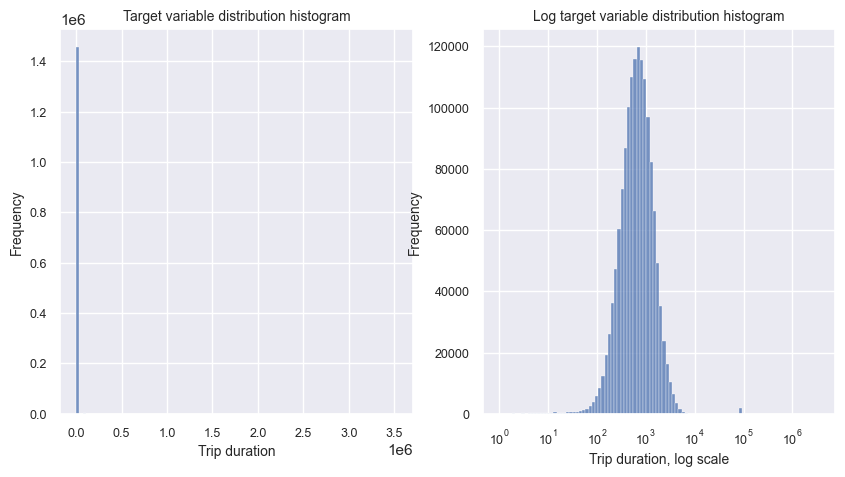

In [5]:
plt.rcParams["figure.figsize"] = (10,5)

fig, ax = plt.subplots(ncols=2)

sns.histplot(data=train, x=target, bins=100, ax=ax[0])
#plot similar histogram with parameter log_scale, choose informative amount of bins and correct axis
#your code here
sns.histplot(data=train, x=target, bins=100, ax=ax[1], log_scale=True)
#end of your code


ax[0].set_title('Target variable distribution histogram', dict(size=10))
ax[0].set_xlabel('Trip duration', dict(size=10))
ax[0].set_ylabel('Frequency', dict(size=10))
ax[0].tick_params(labelsize=9)
ax[1].set_title('Log target variable distribution histogram', dict(size=10))
ax[1].set_xlabel('Trip duration, log scale', dict(size=10))
ax[1].set_ylabel('Frequency', dict(size=10))
ax[1].tick_params(labelsize=9)


**Question**: Why is it necessary to build a histogram in a logarithmic scale?

**Answer**: Logarithmic scales are useful when the data being shown is much smaller or much larger than the rest of the data. In our situation we have trips that differs in the duration a lot and if we draw data in usual scale the graph is not informative.

The competition used RMSLE as a quality metric:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Question**: Why do you think the contest authors chose RMSLE and not RMSE?

**Answer**: RMSLE has the meaning of a relative error - so if we want to equal the matter of small errors on small values with an ordinary errors on ordinary values then we better use RMSLE.

We have discussed several linear regression models in `sklearn`, but each of them optimized the mean square error (MSE), not RMSLE. Let's do the following trick: we will predict not the target variable, but its *logarithm*. Let $\hat{y}_i = \log{(y_i + 1)}$ be the modified target, and $\hat{a}(x_i)$ be the prediction of the model trained on $\hat{y}_i$, that is, the logarithm of the target. To predict the original value, we can simply take the exponent of our prediction: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

In addition, the logarithm of the target has another useful quality. To see it, add the `log_trip_duration` column to our sample (use `np.log1p`) and draw a histogram of the modified target for the training sample. Delete the column with the old target.

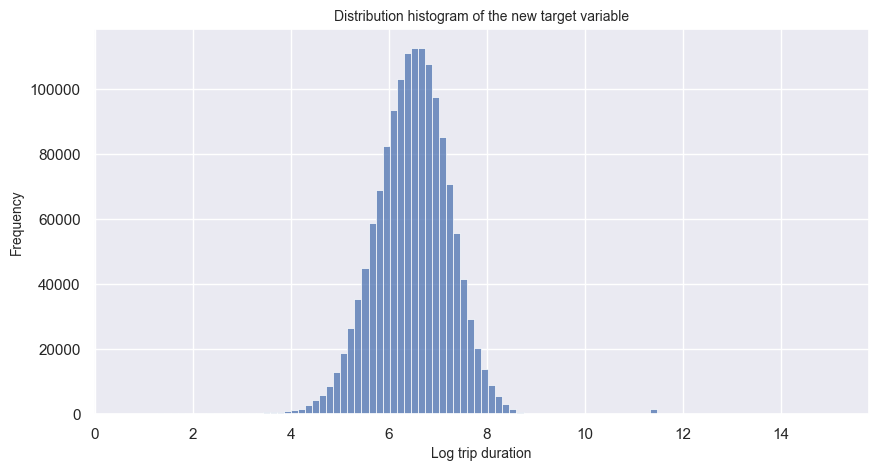

In [6]:
train['log_trip_duration'] = np.log1p(train[target])
#your code to delet target column from train is here:
train = train.drop('trip_duration', axis = 1)
#end of your code
target = 'log_trip_duration'

plt.title('Distribution histogram of the new target variable', dict(size=10))
plt.xlabel('Log trip duration', dict(size=10))
plt.ylabel('Frequency', dict(size=10))
_ = sns.histplot(data=train, x=target, bins=100)

Let's calculate the value of the metric with the best constant prediction:

**Question**: why the best constant for RMSE is mean value?

**Answer**: Because in that case we will have the meaning of standard deviation - so there would not be a better value of an error with any other constant.

In [7]:
def RMSE(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() ** .5

In [8]:
#your code to find constant prediction here:
const_model = train[target].mean()
#end of your code
print('Best constant prediction value: {}'.format(RMSE(train[target], const_model)))

Best constant prediction value: 0.7957592365411509


**Task 2**. First, let's see how many trips there were on each day. Plot the number of trips versus the day of the year:

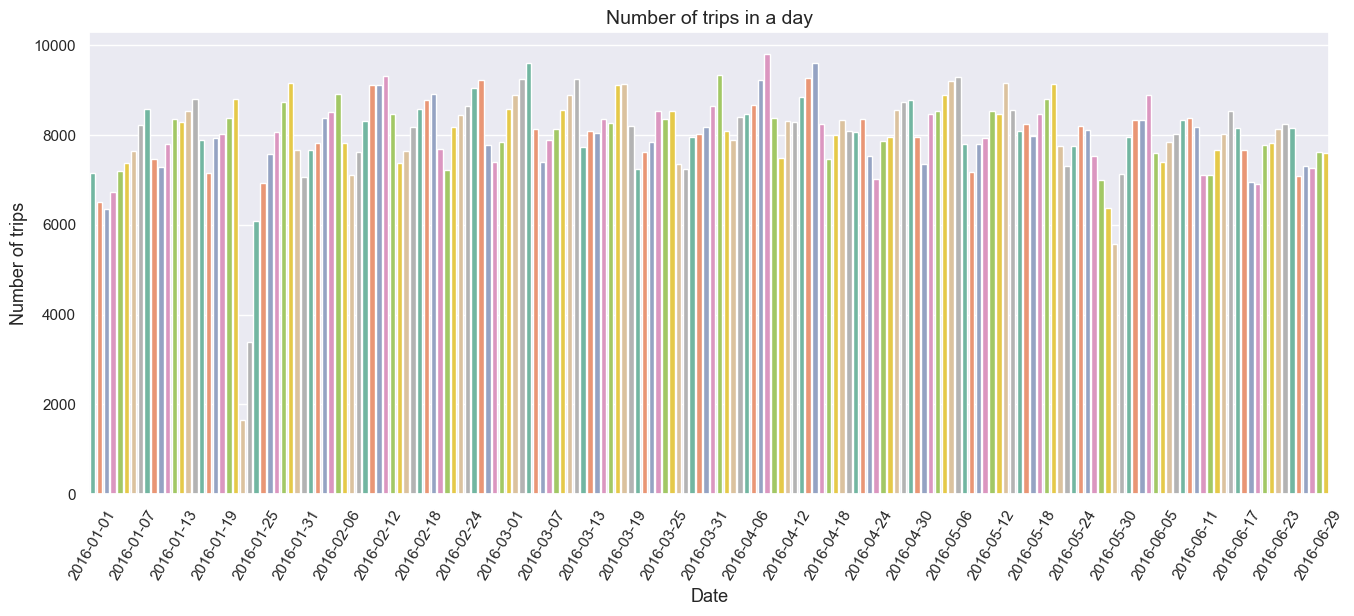

In [9]:
plt.rcParams["figure.figsize"] = (16,6)
train['day_of_year'] = train.pickup_datetime.dt.day_of_year

sns.countplot(x=train['day_of_year'], palette="Set2")

plt.title('Number of trips in a day', dict(size=14))
plt.xlabel('Date', dict(size=13))
plt.ylabel('Number of trips', dict(size=13))

_ = plt.xticks(np.arange(0, 181, 6), np.unique(train.pickup_datetime.dt.date)[::6], rotation=60)

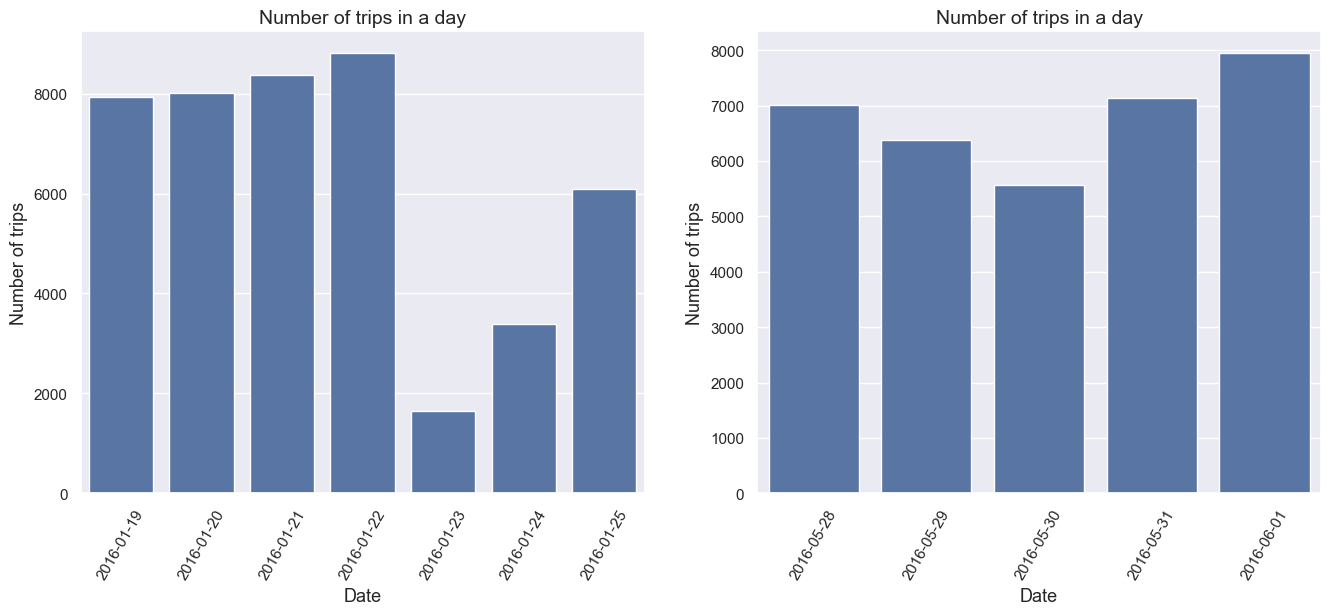

In [10]:
first_period = train.loc[(date.fromisoformat('2016-01-19')<= train.pickup_datetime.dt.date) & (train.pickup_datetime.dt.date <= date.fromisoformat('2016-01-25'))]
second_period = train.loc[(date.fromisoformat('2016-05-28')<= train.pickup_datetime.dt.date) & (train.pickup_datetime.dt.date <= date.fromisoformat('2016-06-01'))]

plt.rcParams["figure.figsize"] = (16,6)
fig, ax = plt.subplots(ncols=2)
sns.countplot(x=first_period['day_of_year'], ax=ax[0])
sns.countplot(x=second_period['day_of_year'], ax=ax[1])
for ax_ in ax:
    ax_.set_title('Number of trips in a day', dict(size=14))
    ax_.set_xlabel('Date', dict(size=13))
    ax_.set_ylabel('Number of trips', dict(size=13))

_ = ax[0].set_xticks(np.arange(0,7), np.unique(first_period.pickup_datetime.dt.date), rotation=60)
_ = ax[1].set_xticks(np.arange(0,5), np.unique(second_period.pickup_datetime.dt.date), rotation=60)

**Question**: You may have noticed that there are 2 periods on the graph with abnormally low numbers of trips. Calculate the dates on which these downward swings occurred and find information about what happened on those days in New York.

**Answer**: First period - 2016-01-23 till 2016-01-25 - there was a tremendous bizzard in US. Second period - 2016-05-29 till 2016-05-30 - rains in New York due to Bonnie tropical storm.

Plot the number of trips versus the day of the week and the hours of the day (use `sns.relplot`):

In [11]:
train['hour'] = train.pickup_datetime.dt.hour
train['day_of_week'] = train.pickup_datetime.dt.day_of_week
train['day_of_year'] = train.pickup_datetime.dt.day_of_year
train['month_name'] = train.pickup_datetime.dt.month_name()

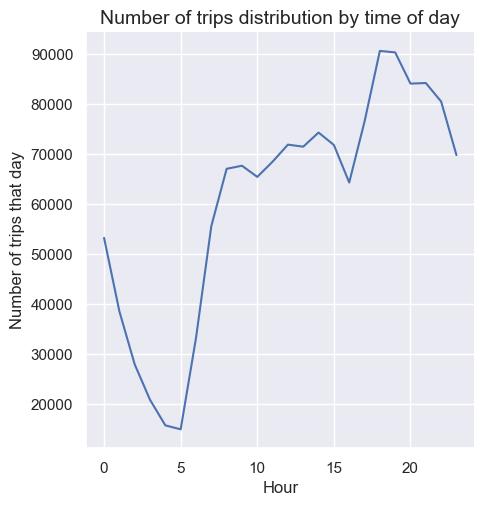

In [12]:
tmp_data = train.groupby('hour').id.count()\
.reset_index().rename({
    'hour': 'Hour',
    'id': 'Number of trips that day'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips that day',
            kind='line')
_ = plt.title('Number of trips distribution by time of day', dict(size=14))

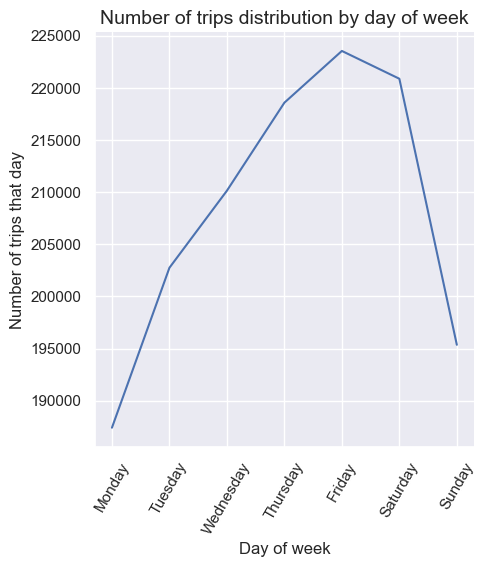

In [13]:
#your code for number of trips distribution by day of week
tmp_data = train.groupby('day_of_week').id.count()\
.reset_index().rename({
    'day_of_week': 'Day of week',
    'id': 'Number of trips that day'},
    axis=1
)
weekdays= ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
sns.relplot(data=tmp_data,
            x='Day of week',
            y='Number of trips that day',
            kind='line')
plt.xticks(np.arange(0,7),weekdays, rotation=60)
_ = plt.title('Number of trips distribution by day of week', dict(size=14))
#end of your code

**Task 3**. Draw on one graph the dependence of the number of trips on the hour of the day for different months (different curves corresponding to different months, color in different colors with use of `hue` in `sns.relplot`). Similarly, draw the dependence of the number of trips on the hour of the day for different days of the week.

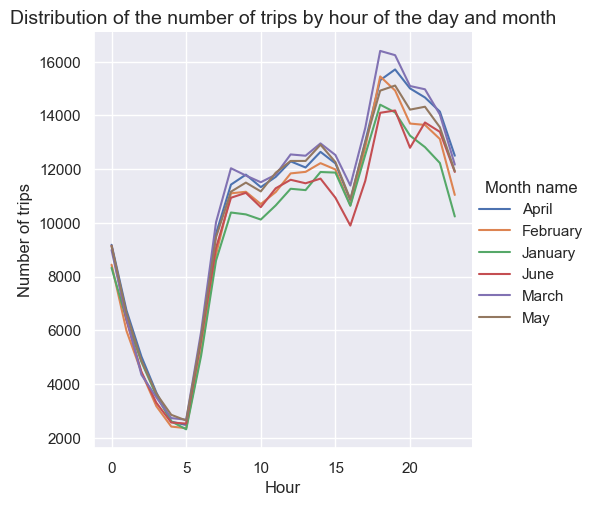

In [14]:
tmp_data = train.groupby(['month_name', 'hour']).id.count()\
.reset_index().rename({
    'month_name': 'Month name',
    'hour': 'Hour',
    'id': 'Number of trips'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips',
            hue='Month name',
            kind='line')
_ = plt.title('Distribution of the number of trips by hour of the day and month', dict(size=14))

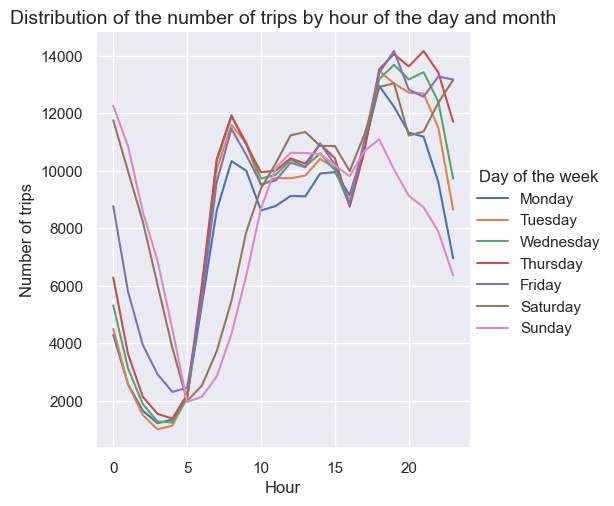

In [15]:
#your code for the dependence of the number of trips on the hour of the day for different days of the week is here:
tmp_data = train.groupby(['day_of_week', 'hour']).id.count()\
.reset_index().rename({
    'day_of_week': 'Day of the week',
    'hour': 'Hour',
    'id': 'Number of trips'},
    axis=1
)
weekdays_dict = {i: weekdays[i] for i in range(len(weekdays)) }
tmp_data = tmp_data.replace({'Day of the week' : weekdays_dict})
sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips',
            hue='Day of the week',
            kind='line')
_ = plt.title('Distribution of the number of trips by hour of the day and month', dict(size=14))

#end of your code

**Question**: What conclusions can be drawn based on the graphs above? Are there any special days of the week? Months? Times of Day? What is it connected with?

**Answer**: If we check first graph - the month lines are rather similar - we can see that the least amount of rides are about 5am, higest rate is between 5-6pm. The graph trend is propably connected with working regime (from 9am to 5pm) - people tend to use taxi to work and from work. Also it can be observed the highest rates are in March and it differs a lot from in January and June - almost for 2000 rides. As for second graph - we can see that the lines of weekends differs from the others. There are more rides during 0-5am and less rides 17, especially on Sunday. 

**Task 4**. Split the sample into train and test (7:3). For the train sample, plot the mean logarithm of travel time versus day of the week. Then do the same, but for the hour of the day and the day of the year.

Add the following traits based on `pickup_datetime`:
1. Day of the week
2. Month
3. Hour
4. Is the period anomalous (two binary signs corresponding to two anomalous periods)
5. Number of the day in the year

In [16]:
train = train.drop('month_name', axis=1)
train['month'] = train.pickup_datetime.dt.month

train['is_anomaly_jan'] = ((23 <= train.day_of_year) & (train.day_of_year <= 26)).astype('int')
train['is_anomaly_may'] = (train.day_of_year == 151).astype('int')

In [17]:
#your code for splitting is here:
train_data, test_data = train_test_split(train, test_size=0.3, random_state=42)
#end of ypur code

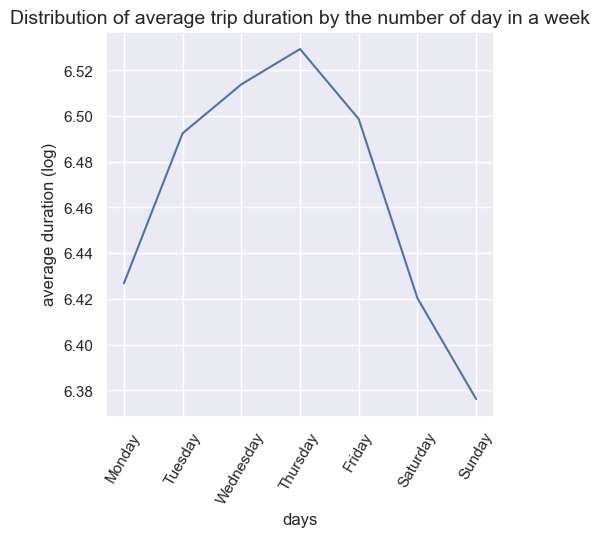

In [18]:
#your code for distribution of average trip duration by the number of day in a week is here:

means = []
for key in weekdays_dict.keys():
    means.append(train_data.loc[train_data['day_of_week'] == key].log_trip_duration.mean())
means = np.array(means)

plt.rcParams["figure.figsize"] = (5,5)
sns.lineplot(x = weekdays_dict.values(), y = means)
plt.xlabel('days')
plt.ylabel('average duration (log)')
plt.xticks(np.arange(0,7), weekdays_dict.values(), rotation=60)
_ = plt.title('Distribution of average trip duration by the number of day in a week', dict(size=14))
#end of your code

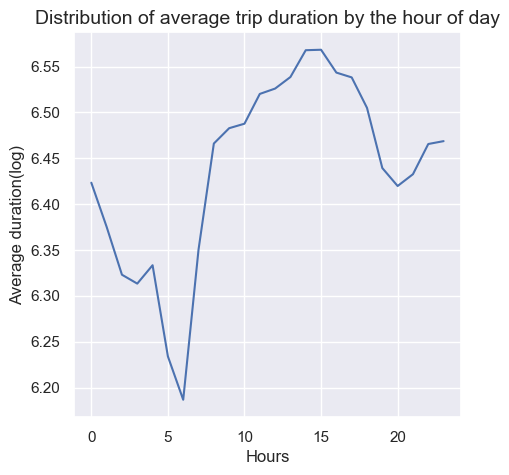

In [19]:
#your code for distribution of average trip duration by the hour of day is here:
means = []
for key in np.arange(0, 24):
    means.append(train_data.loc[(train_data['hour'] == key)].log_trip_duration.mean())
means = np.array(means)

plt.rcParams["figure.figsize"] = (5,5)
sns.lineplot(x = np.arange(0, 24), y = means)
plt.xlabel('Hours')
plt.ylabel('Average duration(log)')
_ = plt.title('Distribution of average trip duration by the hour of day', dict(size=14))
#end of your code

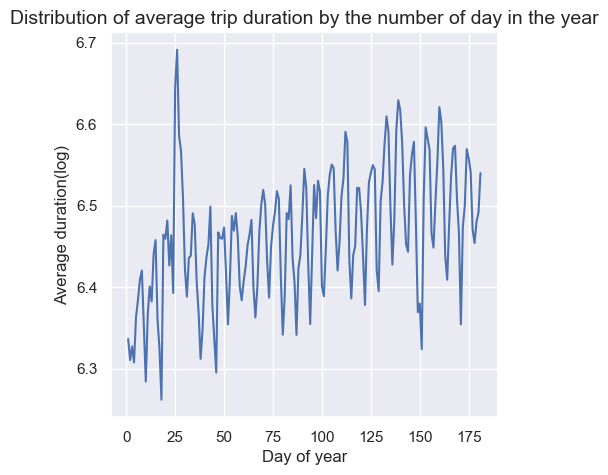

In [20]:
#your code for distribution of average trip duration by the number of day in the year is here:
means = []
for key in np.arange(0, train_data.day_of_year.max()):
    means.append(train_data.loc[train_data['day_of_year'] == key].log_trip_duration.mean())
means = np.array(means)

plt.rcParams["figure.figsize"] = (5,5)
sns.lineplot(x = np.arange(0, train_data.day_of_year.max()), y = means)
plt.xlabel('Day of year')
plt.ylabel('Average duration(log)')
_ = plt.title('Distribution of average trip duration by the number of day in the year', dict(size=14))
#end of your code

**Question**: Are the graphs of the target depending on the day of the week and on the hour of the day similar to those for the number of trips? Why? What happens to the average target in those two anomalous periods that we saw above? Why is this happening? Do you see any trend in the plot of `log_trip_duration` versus day of the year?

**Answer**:
1. Yes, graphs of trips duration and number of trips are similar, especially those who depend on day hours. It seems that people tend to have much less long term rides in the early mornings - we have small rates on both graphs at around 5am.
2. At first "snowy" anomalous period the average trip duration peaks - it may mean that people took priorly long rides. In the second period - average trip duration was comparably low.
3. Overall trand is that the average trip duration is raising.

So, we have already created a number of features.

**Question**: Which of the features should be considered as categorical, and which - as numerical? Why?

**Answer**:  
We have two categorical features - ***id*** (it is not numerical as it contains letters) and ***store_and_fwd_flag*** - it has 2 valyes - *N* and *Y*. Others are numerical, except for ***pickup_datetime*** - it has its own datetime type. By the way, I am not sure if we can call id a feature, further I would not use column ***id*** for training as it not suppose to influence on ride logitudes.

In [21]:
train.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_year,hour,day_of_week,month,is_anomaly_jan,is_anomaly_may
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.96463,40.765602,N,6.122493,74,17,0,3,0,0


**Task 5**. Train `Ridge` regression with default parameters by encoding all categorical features with `OneHotEncoder`. Scale numerical features with `StandardScaler`. Use only the features that we have identified in this part of the task.

In [22]:
def make_pipeline(categorical, numeric, model):

    numeric_transformer = Pipeline(steps=[
          ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
          ('encoder', OneHotEncoder())
    ])
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])

    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    return pipeline

def fit_pipeline(pipeline, train_data, test_data):
#your code to is here:
    pipeline.fit(train_data.drop(target, axis=1), train_data[target])
#end of your code
    train_RMSE = RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))
    test_RMSE = RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))
    print('Train RMSE is {}'.format(train_RMSE))
    print('Test RMSE is {}'.format(test_RMSE))
    return train_RMSE, test_RMSE

In [23]:
#your list of categorical features is here:
categorical_columns = ['store_and_fwd_flag']
#your list of numerical features is here:
numeric_columns = ['vendor_id', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'day_of_year', 'hour', 'day_of_week', 'month', 'is_anomaly_jan',
       'is_anomaly_may']
#your code to create pipeline is here:
pipeline = make_pipeline(categorical_columns, numeric_columns, Ridge() )
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train.drop("id", axis = 1), random_state=42, test_size=0.3))

Train RMSE is 0.7773213565788243
Test RMSE is 0.7782633501010768


(0.7773213565788243, 0.7782633501010768)

**Task 6**. Try to use any other way of categorical features encoding and normalization for numerical features. Train `Ridge` and `Lasso` regression for various encoding options and evaluate the results. Which one turned out to be the best? Why did other options show worse quality?

In [25]:
#your code is here

categorical_encoders = [
    ('one hot encoder', OneHotEncoder()),
    ('ordinal encoder', OrdinalEncoder()), 
]

numerical_scalers = [
    ('standart scaller ', StandardScaler()), 
    ('min max scaler', MinMaxScaler()), 
    ('max abs scaler', MaxAbsScaler()),
    ('robust scaler',  RobustScaler())
]

models = [
    ('Lasso', Lasso()), 
    ('Ridge', Ridge())
]

def make_pipeline_diff_steps(categorical, numeric, model, steps_num, steps_cat):

    numeric_transformer = Pipeline(steps=steps_num)
    categorical_transformer = Pipeline(steps=steps_cat)
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    return pipeline

for model in models:
    for scaler in numerical_scalers:
        for encoder in categorical_encoders:
            best_test_error = (1, 'start')
            best_train_error = (1, 'start')
            print('\nResults for model:{}; Scaler: {}; Encoder: {}'.format(
                model[0], 
                scaler[0], 
                encoder[0]
            ))
            pipeline = make_pipeline_diff_steps(
                categorical_columns, 
                numeric_columns,
                model[1],
                [scaler],
                [encoder]
            )
            train_res, test_res = fit_pipeline(pipeline, *train_test_split(train.drop("id", axis = 1), random_state=42, test_size=0.3))
            if train_res < best_train_error[0]:
                best_train_error = (train_res, (model[0], scaler[0], encoder[0]))
            if test_res < best_test_error[0]:
                best_test_error = (test_res, (model[0], scaler[0], encoder[0]))
#end of your code


Results for model:Lasso; Scaler: standart scaller ; Encoder: one hot encoder
Train RMSE is 0.796072872850926
Test RMSE is 0.795026955552643

Results for model:Lasso; Scaler: standart scaller ; Encoder: ordinal encoder
Train RMSE is 0.796072872850926
Test RMSE is 0.795026955552643

Results for model:Lasso; Scaler: min max scaler; Encoder: one hot encoder
Train RMSE is 0.796072872850926
Test RMSE is 0.795026955552643

Results for model:Lasso; Scaler: min max scaler; Encoder: ordinal encoder
Train RMSE is 0.796072872850926
Test RMSE is 0.795026955552643

Results for model:Lasso; Scaler: max abs scaler; Encoder: one hot encoder
Train RMSE is 0.796072872850926
Test RMSE is 0.795026955552643

Results for model:Lasso; Scaler: max abs scaler; Encoder: ordinal encoder
Train RMSE is 0.796072872850926
Test RMSE is 0.795026955552643

Results for model:Lasso; Scaler: robust scaler; Encoder: one hot encoder
Train RMSE is 0.796072872850926
Test RMSE is 0.795026955552643

Results for model:Lasso; Sca

In [26]:
print(*best_test_error)
print(*best_train_error)

0.7782633565812154 ('Ridge', 'robust scaler', 'ordinal encoder')
0.7773213565926518 ('Ridge', 'robust scaler', 'ordinal encoder')


The best results (minimal RMSE) showed default Ridge model with Robust scaler for numerical features and Ordinal encoder for categorical features. Overall, default Lasso regresson works worse for this problem and the resulting error doesn't change if we use different encoders.

**Task 7**. Split the training sample into train and validation (8:2). On the validation set, find the optimal values of the regularization parameter (on a logarithmic grid) for `Ridge` and `Lasso`, measure the quality of the best obtained model on the test set.

In [27]:
#your code is here
X = train_data.drop([target, 'id'], axis=1)
y = train_data[target]
numeric_transformer = Pipeline(steps=[('robust scaler',  RobustScaler())])
categorical_transformer = Pipeline(steps=[('ordinal encoder', OrdinalEncoder())])
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_columns),
    ('categorical', categorical_transformer, categorical_columns),
])
X_preprocessed = pd.DataFrame(preprocessor.fit_transform(X), columns = numeric_columns + categorical_columns)

Best alpha for model Lasso = 0.004641588833612777
Best alpha for model Ridge = 10.0


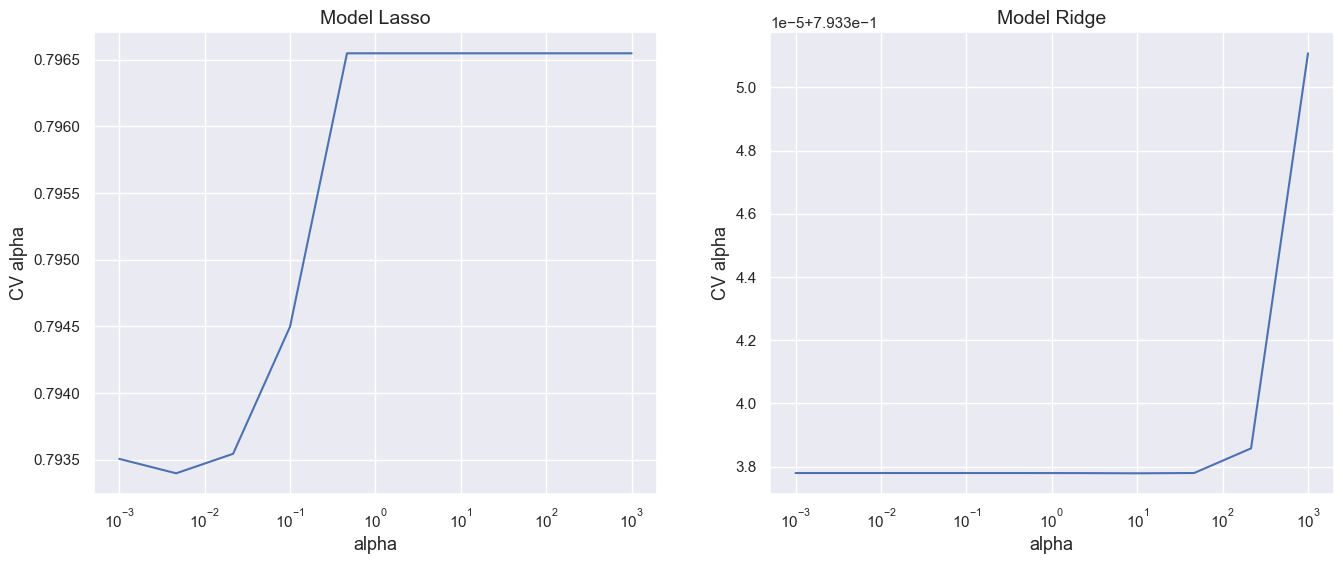

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, random_state=42, test_size=0.2)

plt.rcParams["figure.figsize"] = (16,6)
fig, ax = plt.subplots(ncols=2)
alphas = np.logspace(-3, 3, 10)
for i in range(len(models)):
    searcher = GridSearchCV(models[i][1], [{"alpha": alphas}], scoring='neg_root_mean_squared_error', cv=10, error_score="raise")
    searcher.fit(X_train, y_train)

    best_alpha = searcher.best_params_["alpha"]
    print("Best alpha for model {} = {}".format(models[i][0], best_alpha))
    ax[i].plot(alphas, -searcher.cv_results_["mean_test_score"])
    
    ax[i].set_title('Model {}'.format(models[i][0]), dict(size=14))
    ax[i].set_xlabel('alpha', dict(size=13))
    ax[i].set_ylabel('CV alpha', dict(size=13))
    ax[i].set_xscale("log")
#end of your code

In [29]:
model = Ridge(10)
model.fit(X_train, y_train)
print('Ridge: ')
print('Train RMSE is {}'.format(RMSE(y_train, model.predict(X_train))))
print('Test RMSE is {}'.format(RMSE(y_test, model.predict(X_test))))

Ridge: 
Train RMSE is 0.77898882018831
Test RMSE is 0.771304717265387


In [30]:
model = Lasso(0.004641588833612777)
model.fit(X_train, y_train)
print('Lasso: ')
print(RMSE(y_train, model.predict(X_train)))
print(RMSE(y_test, model.predict(X_test)))

Lasso: 
0.7796195794678253
0.7722309440723947


GridSearchCV identified following best params: 10 for Ridge and 0.004641588833612777 for Lasso.